# Simulated Data Generation

This notebook will explain how to generate the simulated dataset

We first generate a Directed Acyclic Graph (DAG)

In [28]:
import networkx as nx
import numpy as np
from pyrca.simulation.data_gen import DAGGenConfig, DAGGen

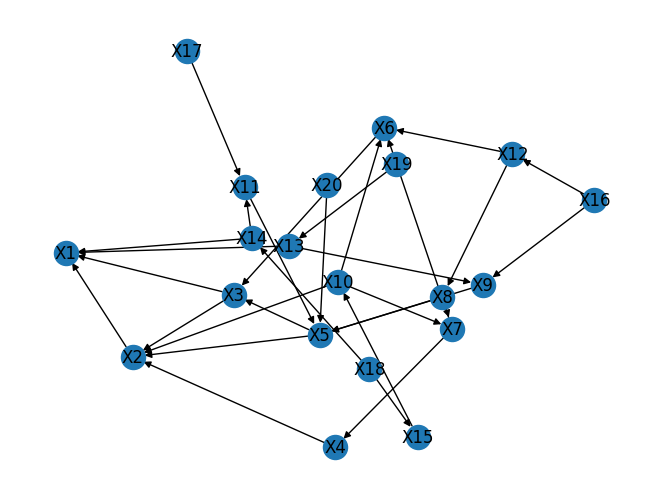

In [43]:
graph_matrix = DAGGen(DAGGenConfig).gen()
G = nx.DiGraph(graph_matrix)

# transform node names from 0 to N-1 to X1 to XN
no_of_var = graph_matrix.shape[0]
original_names = [i for i in range(no_of_var)]
node_names = [("X%d" % (i + 1)) for i in range(no_of_var)]
mapping = dict(zip(original_names, node_names))
G = nx.relabel_nodes(G, mapping)

nx.draw(G, with_labels = True)

Given the dependency graph, we generate data of each node via its Structural Causal Model (SCM). Specifically, $x_{i} = \sum_{x_{j} \in Pa(x_i)} A_{ij} f_i(x_j) +  \beta_i * noise_i$.

Here, $A_{ij}$ and $\beta_i$ are parent weights and noise weights, respectively. They are randomly generated via either normal distrbution or uniform distribution. We can also select the noise type and function type.

In [18]:
from pyrca.simulation.data_gen import DataGenConfig, DataGen

config = DataGenConfig(dag=graph_matrix, func_type='square', noise_type='laplace', weight_generator='normal')
normal_data, parent_weights, noise_weights, func_form, noise_form = DataGen(config).gen()

In [19]:
normal_data

array([[-6.45346205e+14,  9.95071471e+00,  2.61017917e+07, ...,
         2.70886158e+00,  4.89874005e-04, -1.02040755e+00],
       [-3.03372140e+80,  2.14116335e+20,  1.78962396e+40, ...,
         2.32309096e+00, -3.23375881e-01, -3.59206763e+00],
       [-1.71486163e+03, -1.49018187e+01,  3.98093187e+01, ...,
        -3.43994736e-01, -6.60491201e-01, -3.43036142e+00],
       ...,
       [-1.22163244e+28,  1.25327544e+02,  1.13564925e+14, ...,
        -1.33148991e-01, -1.64537688e-02, -1.23441129e+00],
       [-2.31478742e+22,  2.84533756e+04,  1.56325381e+11, ...,
        -6.22024816e-01,  5.88810085e-01,  4.11518695e-01],
       [-4.15987543e+21,  4.12006784e+05,  6.62695622e+10, ...,
        -8.40857256e-01,  5.61372890e-01,  1.44187539e-01]])

Then, we consider to inject faults into the normal distribution to generate abnormal data. 

We first compute the baseline of Service Level Indicator (SLI) and the threshold for differentiating normal and anomaly data.

In [20]:
_SLI = 0
tau = 3
baseline = normal_data[_SLI, :].mean()
sli_sigma = normal_data[_SLI, :].std()
threshold = tau * sli_sigma

We can choose one of three ways to inject anomaly. Type 0 is to change the weight of noise term. Type 1 is to add a constant shift to noise term. Type 2 is to change the weight of parent nodes.

In [23]:
from pyrca.simulation.data_gen import AnomalyDataGenConfig, AnomalyDataGen

config = AnomalyDataGenConfig(parent_weights=parent_weights, 
                              noise_weights=noise_weights, 
                              func_type=func_form,
                              noise_type=noise_form,
                              threshold=threshold,
                              baseline=baseline, 
                              anomaly_type=0)
anomaly_data, fault = AnomalyDataGen(config).gen()

Finally, we plot the graph with root causes

The generated graph: True is directed and acyclic.


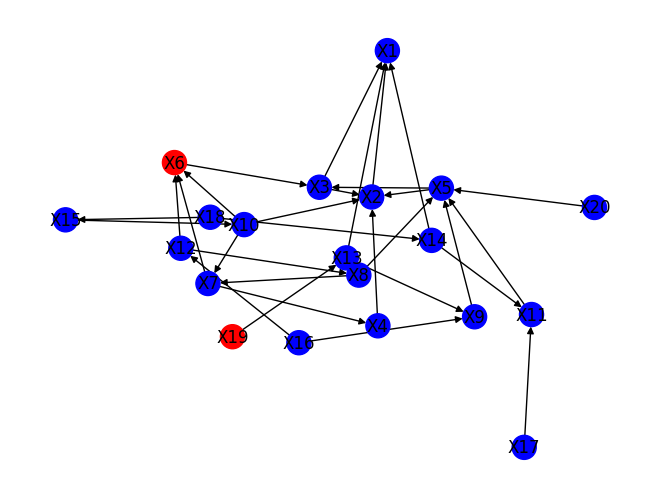

In [44]:
# constructure networkx graph from adjacent matrix
G = nx.DiGraph(graph_matrix)

# transform node names from 0 to N-1 to X1 to XN
no_of_var = graph_matrix.shape[0]
original_names = [i for i in range(no_of_var)]
node_names = [("X%d" % (i + 1)) for i in range(no_of_var)]
mapping = dict(zip(original_names, node_names))
G = nx.relabel_nodes(G, mapping)

# label the root cause nodes 
no_of_var = graph_matrix.shape[0]
color_list = np.array(['blue','red'])
node_color_idx = np.zeros(no_of_var).astype(int)
node_color_idx[fault != 0] = 1
node_color = color_list[node_color_idx]
print(f"The generated graph: {nx.is_directed_acyclic_graph(G)} is directed and acyclic.")
nx.draw(G, with_labels = True, node_color=node_color)